The SQuAD(Stanford Question Answer Dataset) is in JSON format and is very convoluted.

In this notebook I will convert the JSON dataset to a clean DataFrame and generate visualizations to understand the SQuAD dataset.

# Importing Libraries

In [178]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Importing training and development raw json dataset

In [179]:
train_input_file_path = 'data/train-v2.0.json'
dev_input_file_path = 'data/dev-v2.0.json'
json_record_path = ['data', 'paragraphs', 'qas', 'answers']

In [180]:
file = json.loads(open('data/train-v2.0.json').read())

# Visualizing a passage and a question in the json training dataset

In [181]:
file['data'][0]['paragraphs'][0]['context']

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [182]:
file['data'][0]['paragraphs'][0]['qas'][0]

{'question': 'When did Beyonce start becoming popular?',
 'id': '56be85543aeaaa14008c9063',
 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
 'is_impossible': False}

# Preprocessing json data to Dataframe

In [183]:
def squad_json_to_dataframe(input_file_path, json_record_path=['data','paragraphs','qas','answers'], verbose=1, train = True):
    """
    input_file_path: this is the path to the squad train or development json file.
    record_path: path to deepest level in json file default value is ['data','paragraphs','qas','answers']
    by default verbose is 1 
    """
    if verbose:
        print("Reading the json file")
        
    # loading the json file
    file = json.loads(open(input_file_path).read())
    
    if verbose:
        print("Processing...")
        
    # Parse different levels in the json file
    js = pd.io.json.json_normalize(file, json_record_path)
    m = pd.io.json.json_normalize(file, json_record_path[:-1])
    r = pd.io.json.json_normalize(file, json_record_path[:-2])
    
    # Combine it into single DataFrame
    idx = np.repeat(r['context'].values, r.qas.str.len())
    # unlike training dataset development dataset is in different json format like development dataset has multiple answers for a single question
    if train:
        ndx  = np.repeat(m['id'].values, m['answers'].str.len())
        m['context'] = idx
        js['q_idx'] = ndx
        main = pd.concat([m[['id', 'question', 'context']].set_index('id'), js.set_index('q_idx')], 1, sort=False).reset_index()
        main['c_id'] = main['context'].factorize()[0]
    else:
        m['context'] = idx
        main = m[['id', 'question', 'context', 'answers']].set_index('id').reset_index()
        main['c_id'] = main['context'].factorize()[0]
        
    if verbose:
        print("Shape of the dataframe is {}".format(main.shape))
        print("Done")
        
    return main

In [184]:
train = squad_json_to_dataframe(train_input_file_path, record_path=record_path, train = True)

TypeError: squad_json_to_dataframe() got an unexpected keyword argument 'record_path'

In [185]:
dev = squad_json_to_dataframe(dev_input_file_path, record_path=record_path, train = False)

TypeError: squad_json_to_dataframe() got an unexpected keyword argument 'record_path'

# Visualizing 5 samples of training and development dataframe

In [186]:
train.sample(5)

,index,question,context,answer_start,text,c_id,question wc
46887,571a354b4faf5e1900b8a91c,How long does sensory memory to to store info...,Sensory memory holds sensory information less ...,41.0,less than one second,7473,9
120580,57315cc8e6313a140071ce85,Who wrote the Communist Manifesto?,Karl Marx published the Communist Manifesto in...,0.0,Karl Marx,17575,5
43942,5ad36796604f3c001a3fe09c,How many ministers did Elizabeth consult befor...,The Suez crisis and the choice of Eden's succe...,NaN,NaN,7066,13
91245,5729315c3f37b319004780d3,What did the people educated in Western Europe...,Kaszycka et al. (2009) in 2002–2003 surveyed E...,337.0,race,13544,17
43255,570e2db80b85d914000d7d14,Who isolated radium in uranium ore?,The discovery and isolation of radium in urani...,70.0,Marie Curie,6987,6


In [187]:
dev.sample(5)

,id,question,context,answers,c_id
4311,7e1e4fceda55a2fcf3cdddbb8,Who has the Islamic Liberation Party never at...,Another of the Egyptian groups which employed ...,[],453
4071,05b7fd3b712c9b7cda7fe99a6,What aspects of life does Islamism not seek t...,"Islamism, also known as Political Islam (Arabi...",[],429
3987,ece4d9dec641eff63201022fc,How many days does the Parliament have to nomi...,"Under the Scotland Act 1998, ordinary general ...","[{'text': '28', 'answer_start': 499}, {'text':...",420
156,37a69cefaca29a42db43f6ee6,Who's chains were made out of copper?,Various princes of the Holy Land arrived in Li...,[],27
4622,4d87ce4e37f1008aaabe5eb3e,What weapons were the Zulus using during the ...,"Along with advancements in communication, Euro...",[],485


# Saving datasets using pickle

In [188]:
trainfile = open('squad_train','wb')
devfile = open('squad_dev','wb')
pickle.dump(train,trainfile)
pickle.dump(dev,devfile)
trainfile.close()
devfile.close()

# Visualizing training questions word count

In [189]:
train['question wc'] = train['question'].apply(lambda x : len(x.split()))

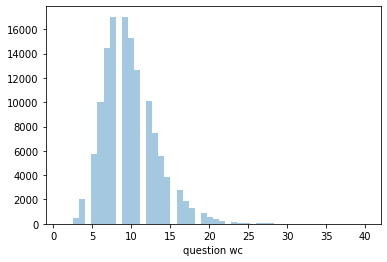

In [190]:
sns.distplot(train['question wc'],  kde=False, label='train')

In [191]:
train['question wc'] >= 30
cnt = 0
for i in range(len(train)):
    if train.iloc[i]['question wc'] >= 30:
        cnt += 1

In [192]:
print (((len(train) - cnt) * 100 / len(train))) 

99.97314282644895


*99.98 percent of training questions are under 30 words*

# Visualizing training paragraphs word count

In [193]:
paragraphs = train["context"]

In [194]:
paragraphs.head()

0    Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1    Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
2    Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
3    Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
4    Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
Name: context, dtype: object

In [195]:
paragraphs = paragraph.drop_duplicates()

In [196]:
len(paragraphs)

19029

There are totally 19030 passages in training dataset

In [197]:
paragraphs['wc'] = paragraphs.iloc[:].apply(lambda x : len(x.split()))

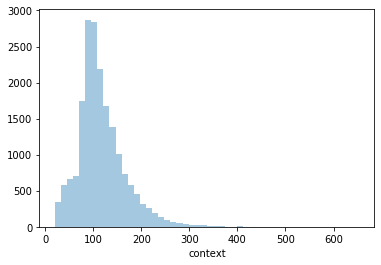

In [198]:
sns.distplot(paragraphs['wc'],  kde=False, label='train')

In [199]:
paragraphs['wc'] >= 400
cnt = 0
for i in range(len(train)):
    if train.iloc[i]['question wc'] >= 30:
        cnt += 1

In [200]:
print (((len(paragraphs) - cnt) * 100 / len(paragraphs))) 

99.81607987388334


99.8 percent of paragraphs are under 400 words